In [1]:
#!/usr/bin/env python
# coding: utf-8

# Load packages

In [1]:
from IPython import get_ipython

In [ ]:
if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import scanpy as sc
import latenta as la
import jax
import jax.numpy as jnp
import optax
import tqdm.auto as tqdm
import scipy
import random
import re
import dill as pickle
import sklearn.decomposition
import os
import eyck
from general_functions.model_generation_functions import *
from general_functions.model_visualization_functions import *

/srv/data/robinve/miniconda3/envs/latenta/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Unpack the data

In[12]:

To load the pickled AnnData object back into memory

In [ ]:
with open("../../real_data/wild_type_cells.pkl", "rb") as f:
    adata = pickle.load(f)

In [5]:
base_model = create_base_model(adata)

In [3]:
def map_nested_fn(fn):
    """Recursively apply `fn` to key-value pairs of a nested dict."""
    def map_fn(nested_dict):
        return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v)) for k, v in nested_dict.items()}
    return map_fn

In [4]:
@map_nested_fn
def label_fn(k, v):
    # print(k)
    if ("kernel" in k) or ("bias" in k):
        return "a"
    else:
        return "b"

In [5]:
optimizer = optax.multi_transform({"b": optax.adam(5e-3), "a": optax.adam(1e-4)}, label_fn)

In [9]:
adata.X = adata.X.toarray()
adata.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.7578579 ],
       [0.        , 0.        , 0.28291035, ..., 0.        , 0.        ,
        0.6835809 ],
       [0.        , 0.        , 0.6585069 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.67586887, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [10]:
pca,cells,X =adata_pca(adata)
x = latent_x(pca,cells,X)
initialization_func1 = lambda: unbiased_initialization(x)
initialization_func1.__name__ = 'unbiased_initialization'
x_bias_loc_list = pre_caluclate_pca_biases(pca,cells,X)
placeholder = [0]
initialization_func2 = lambda: semi_biased_initialization(x,x_bias_loc_list, placeholder[0])
initialization_func2.__name__ = 'semi_biased_initialization'
initialization_funcs = [initialization_func1, initialization_func2]


In [ ]:
initialization_funcs = [initialization_func1]

In [12]:
np.random.seed(42)

In [ ]:
with open("random_model/scores.pkl", "rb") as f:
    unbiased_scores = pickle.load(f)
with open("random_model/dictionary.pkl", "rb") as f:
    unbiased_dictionary = pickle.load(f)

In [15]:
relevant_unbiased_scores = unbiased_scores[unbiased_scores["initialisation"] == "unbiased_initialization"]

In [16]:
best_model_name = relevant_unbiased_scores.iloc[relevant_unbiased_scores["elbo"].idxmax()]["model_name"]
best_original_model = unbiased_dictionary["unbiased_initialization"][0][best_model_name][0]

In [ ]:
def pruning (best_model, n_removals:int=2):
    architecture = get_architecture_name(best_model)
    all_scores, new_model_dict = latenta_processes_basic(best_model, optimizer, architecture, architecture+f"_0_0", 1)
    all_scores["generation"] = 0
    all_model_dict = {}
    all_model_dict[0] = new_model_dict
    for i in range(n_removals):
        generation = i+1
        lfc =best_model.find("lfc")
        dict = lfc.components
        model = best_model
        scores = pd.DataFrame() 
        all_model_dict[generation] = {}
        model_dict = all_model_dict[generation]
        for j,key in enumerate(list(dict.keys())):
            new_model = model.clone()
            new_model.find("lfc").remove_component(key)
            architecture = get_architecture_name(new_model)
            new_scores, new_model_dict = latenta_processes_basic(new_model, optimizer, architecture, architecture+f"_{str(generation)}_{str(j)}", 1000)
            new_scores["generation"] = generation
            scores = pd.concat([scores, new_scores], axis=0, ignore_index=True)
            model_dict.update(new_model_dict)

            best_model_name = scores.loc[scores['elbo'].idxmax()]["model_name"]
            best_model = model_dict[best_model_name][0]
        all_scores = pd.concat([all_scores, scores], axis=0, ignore_index=True)

        print(generation)

    return all_scores, all_model_dict

In [ ]:
all_scores, all_model_dict = pruning(best_original_model, 3)

100%|██████████| 1000/1000 [01:21<00:00, 12.25it/s]


1


100%|██████████| 1000/1000 [01:14<00:00, 13.43it/s]


2


100%|██████████| 1000/1000 [01:02<00:00, 16.00it/s]


3


In [ ]:
safe_pickle(all_model_dict, "dictionary.pkl", "pruning")
safe_pickle(all_scores, "scores.pkl", "pruning")

In [ ]:
with open("pruning/scores.pkl", "rb") as f:
    all_scores = pickle.load(f)
with open("pruning/dictionary.pkl", "rb") as f:
    all_model_dict = pickle.load(f)

/tmp/ipykernel_1647526/756633566.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")  # Purple-to-yellow colormap


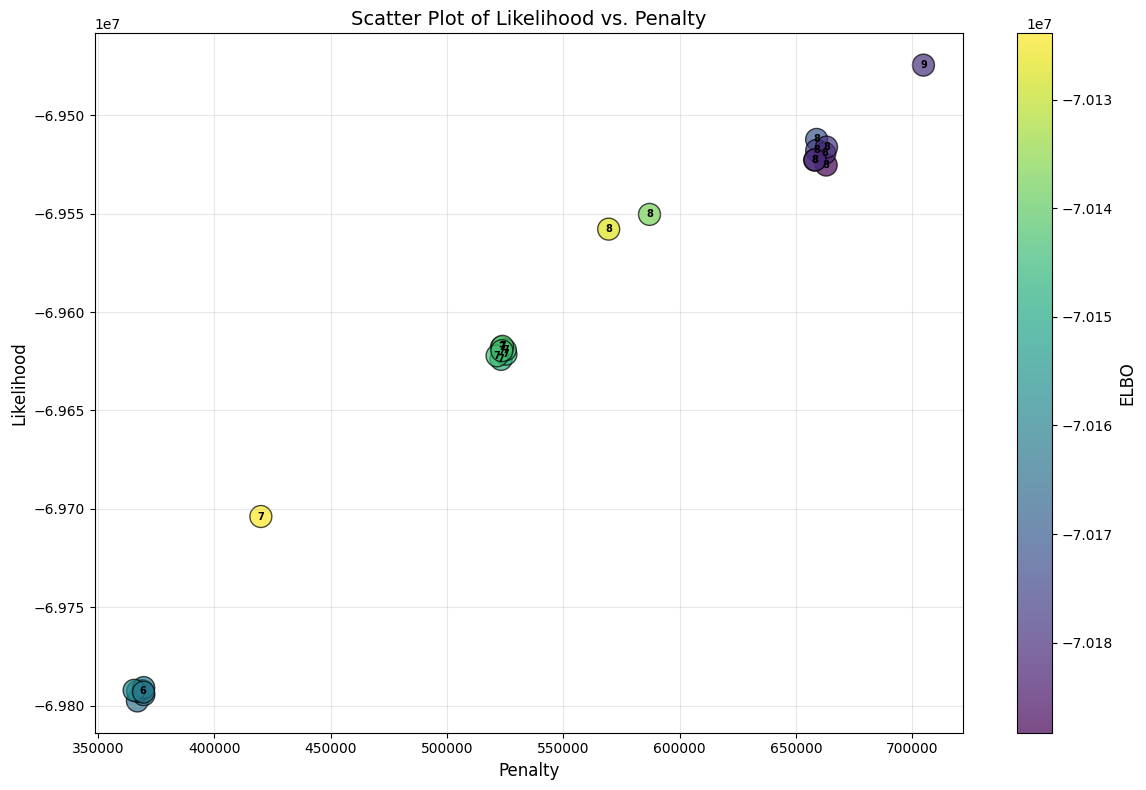

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Add a new column for grouping
def group_model(row):
    return str(row["number_of_effects"])  # Ensure group numbers are strings for annotation

all_scores["group"] = all_scores.apply(group_model, axis=1)

# Normalize ELBO for the color mapping
norm = mcolors.Normalize(vmin=all_scores["elbo"].min(), vmax=all_scores["elbo"].max())
cmap = cm.get_cmap("viridis")  # Purple-to-yellow colormap

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot with group numbers as "markers"
scatter = ax.scatter(
    x=all_scores["penalty"],
    y=all_scores["lik"],
    c=all_scores["elbo"],
    cmap=cmap,
    norm=norm,
    edgecolor="black",
    alpha=0.7,
    s=250,  # Size of scatter points
)
alpha = 1
counter = 0
# Annotate each point with its group number
for _, row in all_scores.iterrows():
    
    if row["group"] == "6":
        counter += 1
        if counter >1:
            alpha = 0
        
    ax.text(
        x=row["penalty"],
        y=row["lik"],
        s=row["group"],  # Use group number as text
        fontsize=7,
        ha="center",
        va="center",
        color="black",
        fontweight="bold",
        alpha = alpha
    )

# Add a colorbar for the ELBO
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label("ELBO", fontsize=12)

# Add labels and title
ax.set_xlabel("Penalty", fontsize=12)
ax.set_ylabel("Likelihood", fontsize=12)
ax.set_title("Scatter Plot of Likelihood vs. Penalty", fontsize=14)

# Add grid and adjust layout
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [5]:
all_scores["relative_elbo"] = all_scores["elbo"] - all_scores["elbo"].min()
all_scores["relative_lik"] = all_scores["lik"] - all_scores["lik"].min()
all_scores["relative_penalty"] = all_scores["penalty"] - all_scores["penalty"].min()
all_scores = all_scores.reset_index()

In [6]:
all_scores.style.bar(subset=["relative_elbo", "relative_lik", "relative_penalty"], cmap="Reds")

In [7]:
def count_effects(architecture):
    if architecture in ["unbiased_initialization_biased_model", "biased_initialization_biased_model"]:
        return 3  # Base model always has 3 effects
    return len(architecture) // 3  # Each effect is 3 letters

# Apply the function to create the new column
all_scores["number_of_effects"] = all_scores["architecture"].apply(count_effects)

/tmp/ipykernel_1647526/307646073.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_scores, x="group", y="elbo", order=group_order, palette="Set3", )


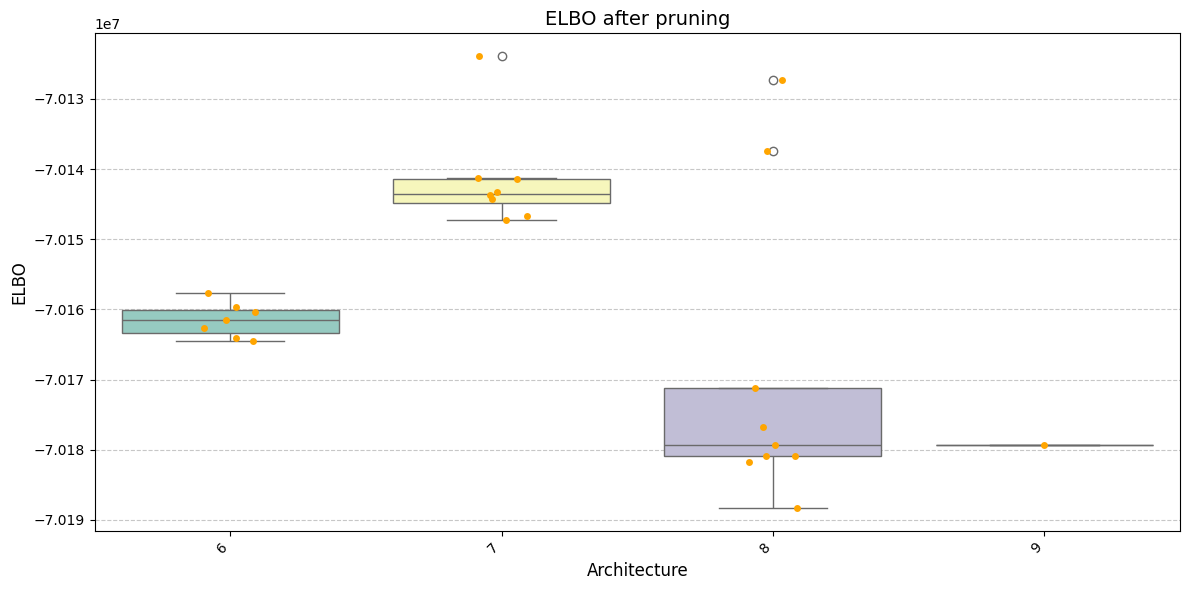

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Add a new column for grouping
def group_model(row):
    return f"{row['number_of_effects']}"

all_scores["group"] = all_scores.apply(group_model, axis=1)

# Sort the groups to ensure consistent ordering
group_order = (
    sorted([g for g in all_scores["group"].unique()]))


# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_scores, x="group", y="elbo", order=group_order, palette="Set3", )
# adding data points 
sns.stripplot(data=all_scores, x="group", y="elbo", order=group_order, color='orange') 
# Add labels and title
plt.xlabel("Architecture", fontsize=12)
plt.ylabel("ELBO", fontsize=12)
plt.title("ELBO after pruning", fontsize=14)
plt.xticks(rotation=45, fontsize=10, ha="right")
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
best_model_name = all_scores.iloc[all_scores["elbo"].idxmax()]["model_name"]
generation = all_scores.iloc[all_scores["elbo"].idxmax()]["generation"]
best_model = all_model_dict[generation][best_model_name][0]

In [9]:
adata = data_adata_converter(best_model)

In [17]:
original_adata = data_adata_converter(best_original_model)

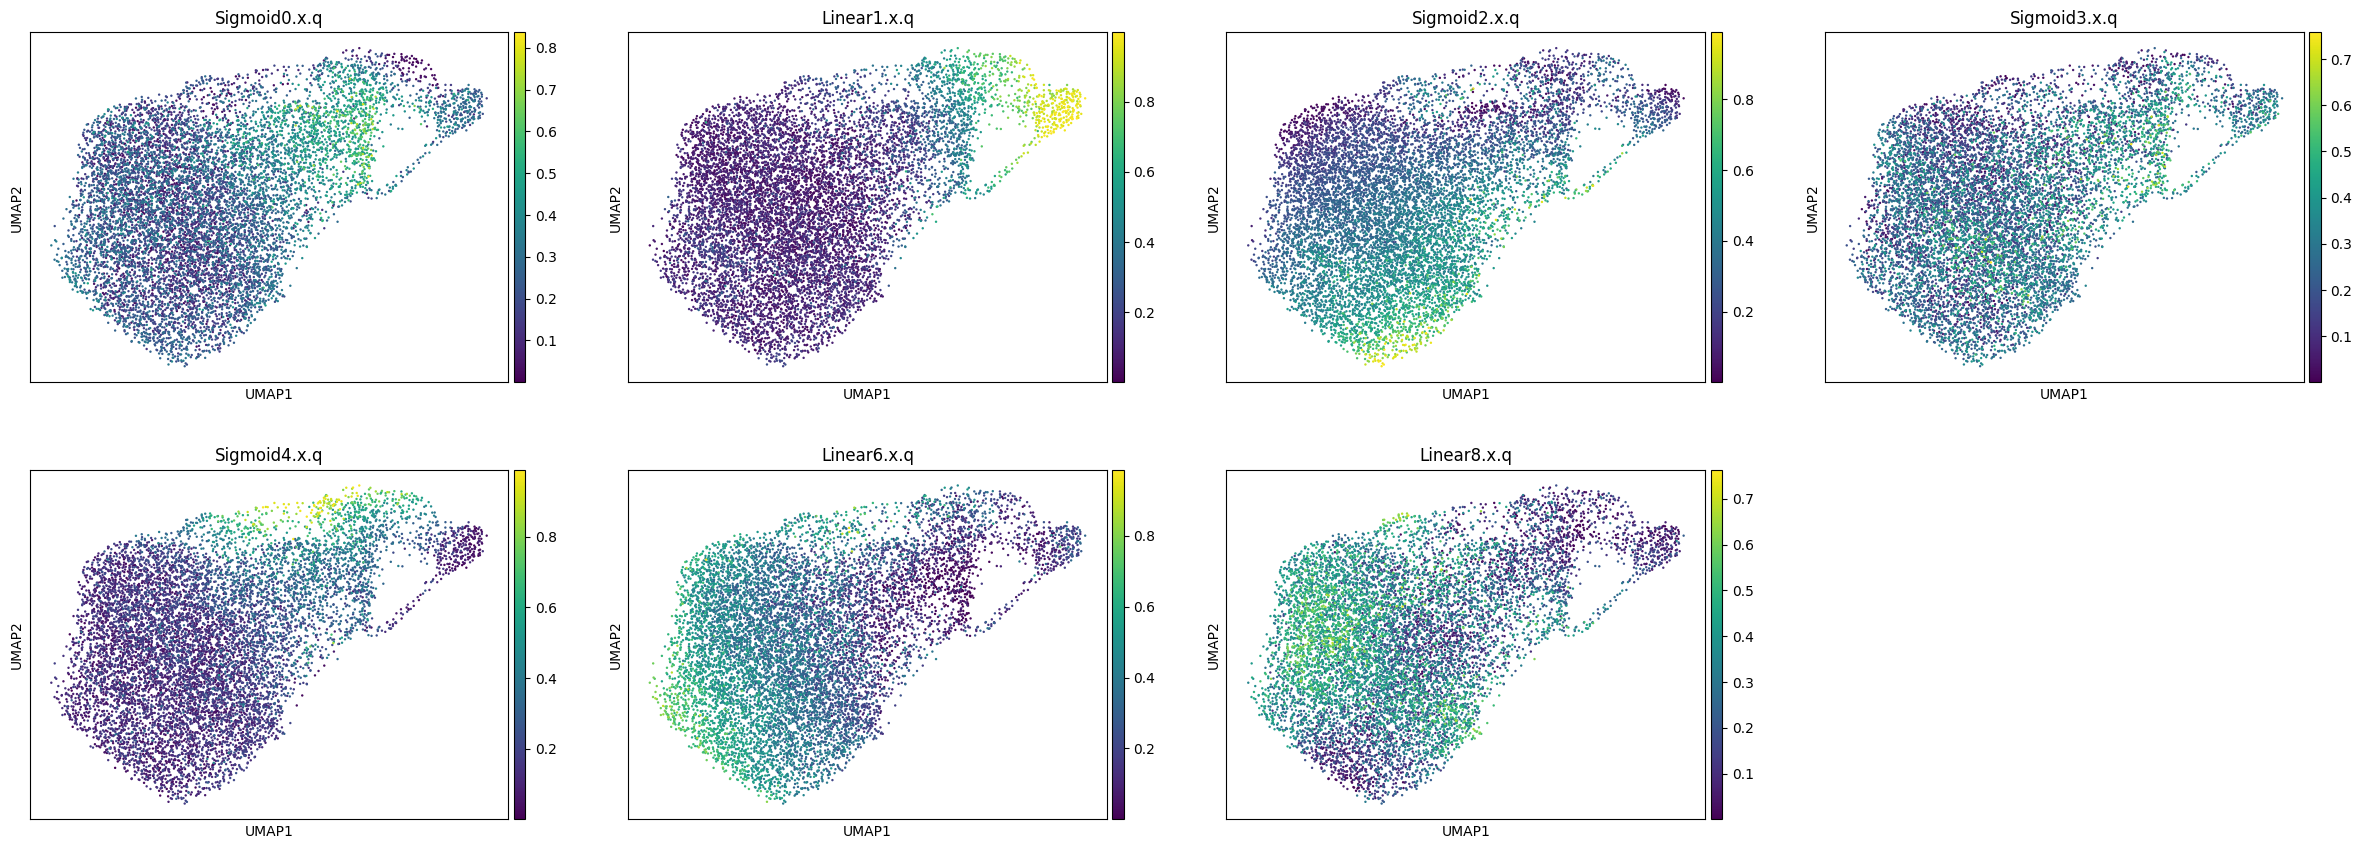

In [44]:
sc.pl.umap(adata, color=adata.obs.columns)

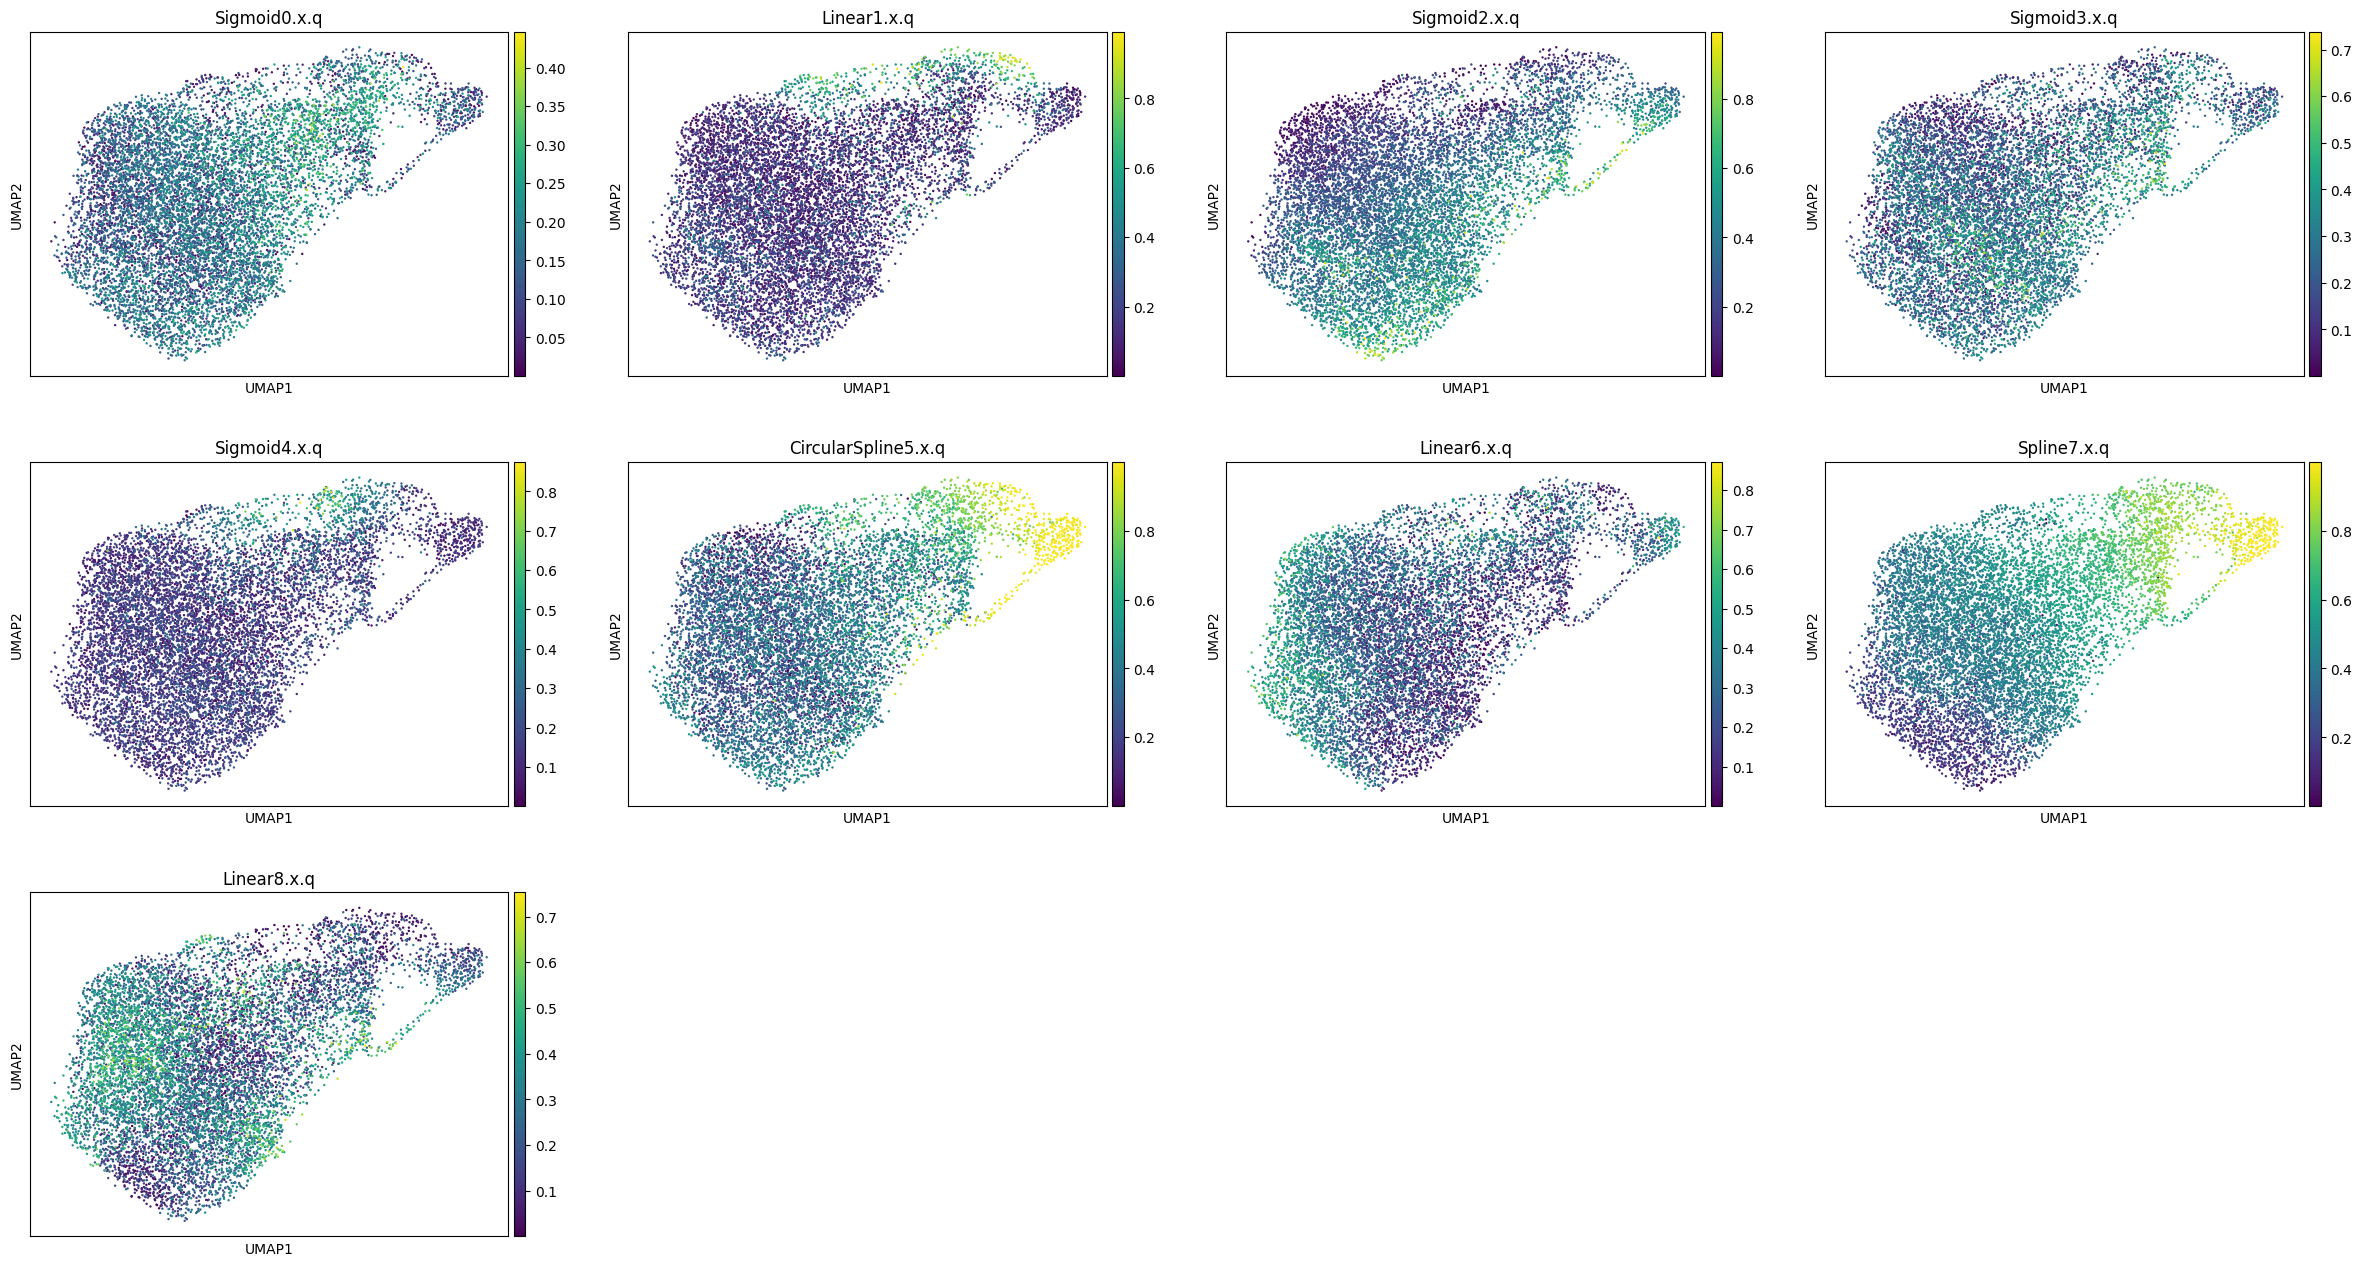

In [47]:
sc.pl.umap(original_adata, color=original_adata.obs.columns)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


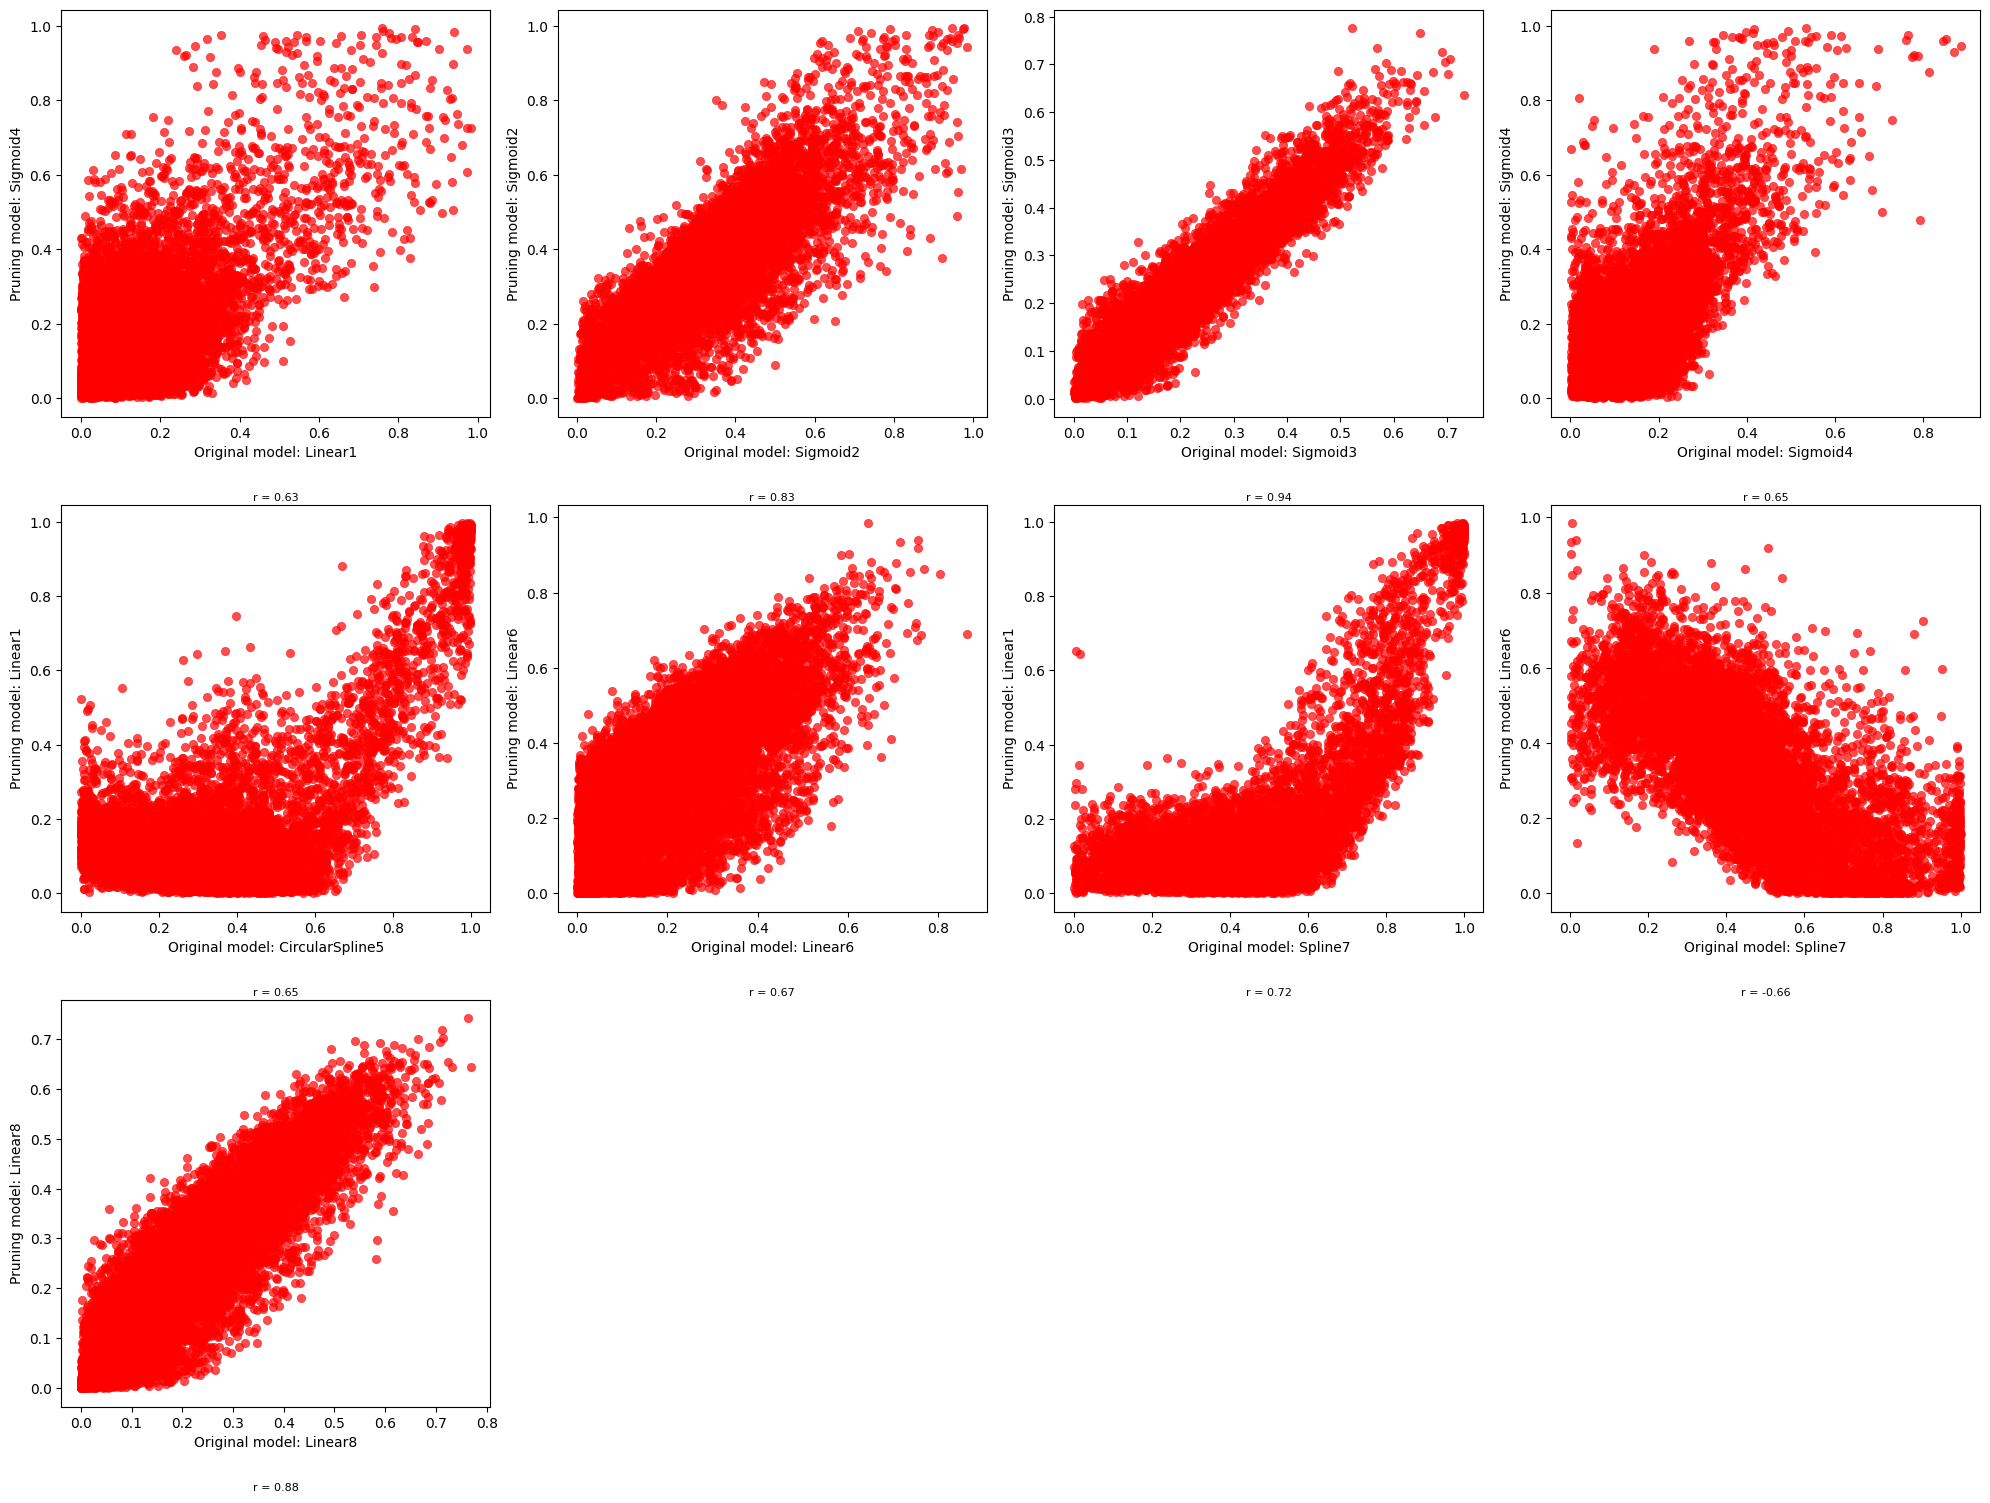

In [19]:
compare_adata_obs(original_adata,adata,name1="Original model",name2="Pruning model", threshold=0.5, compact=True)

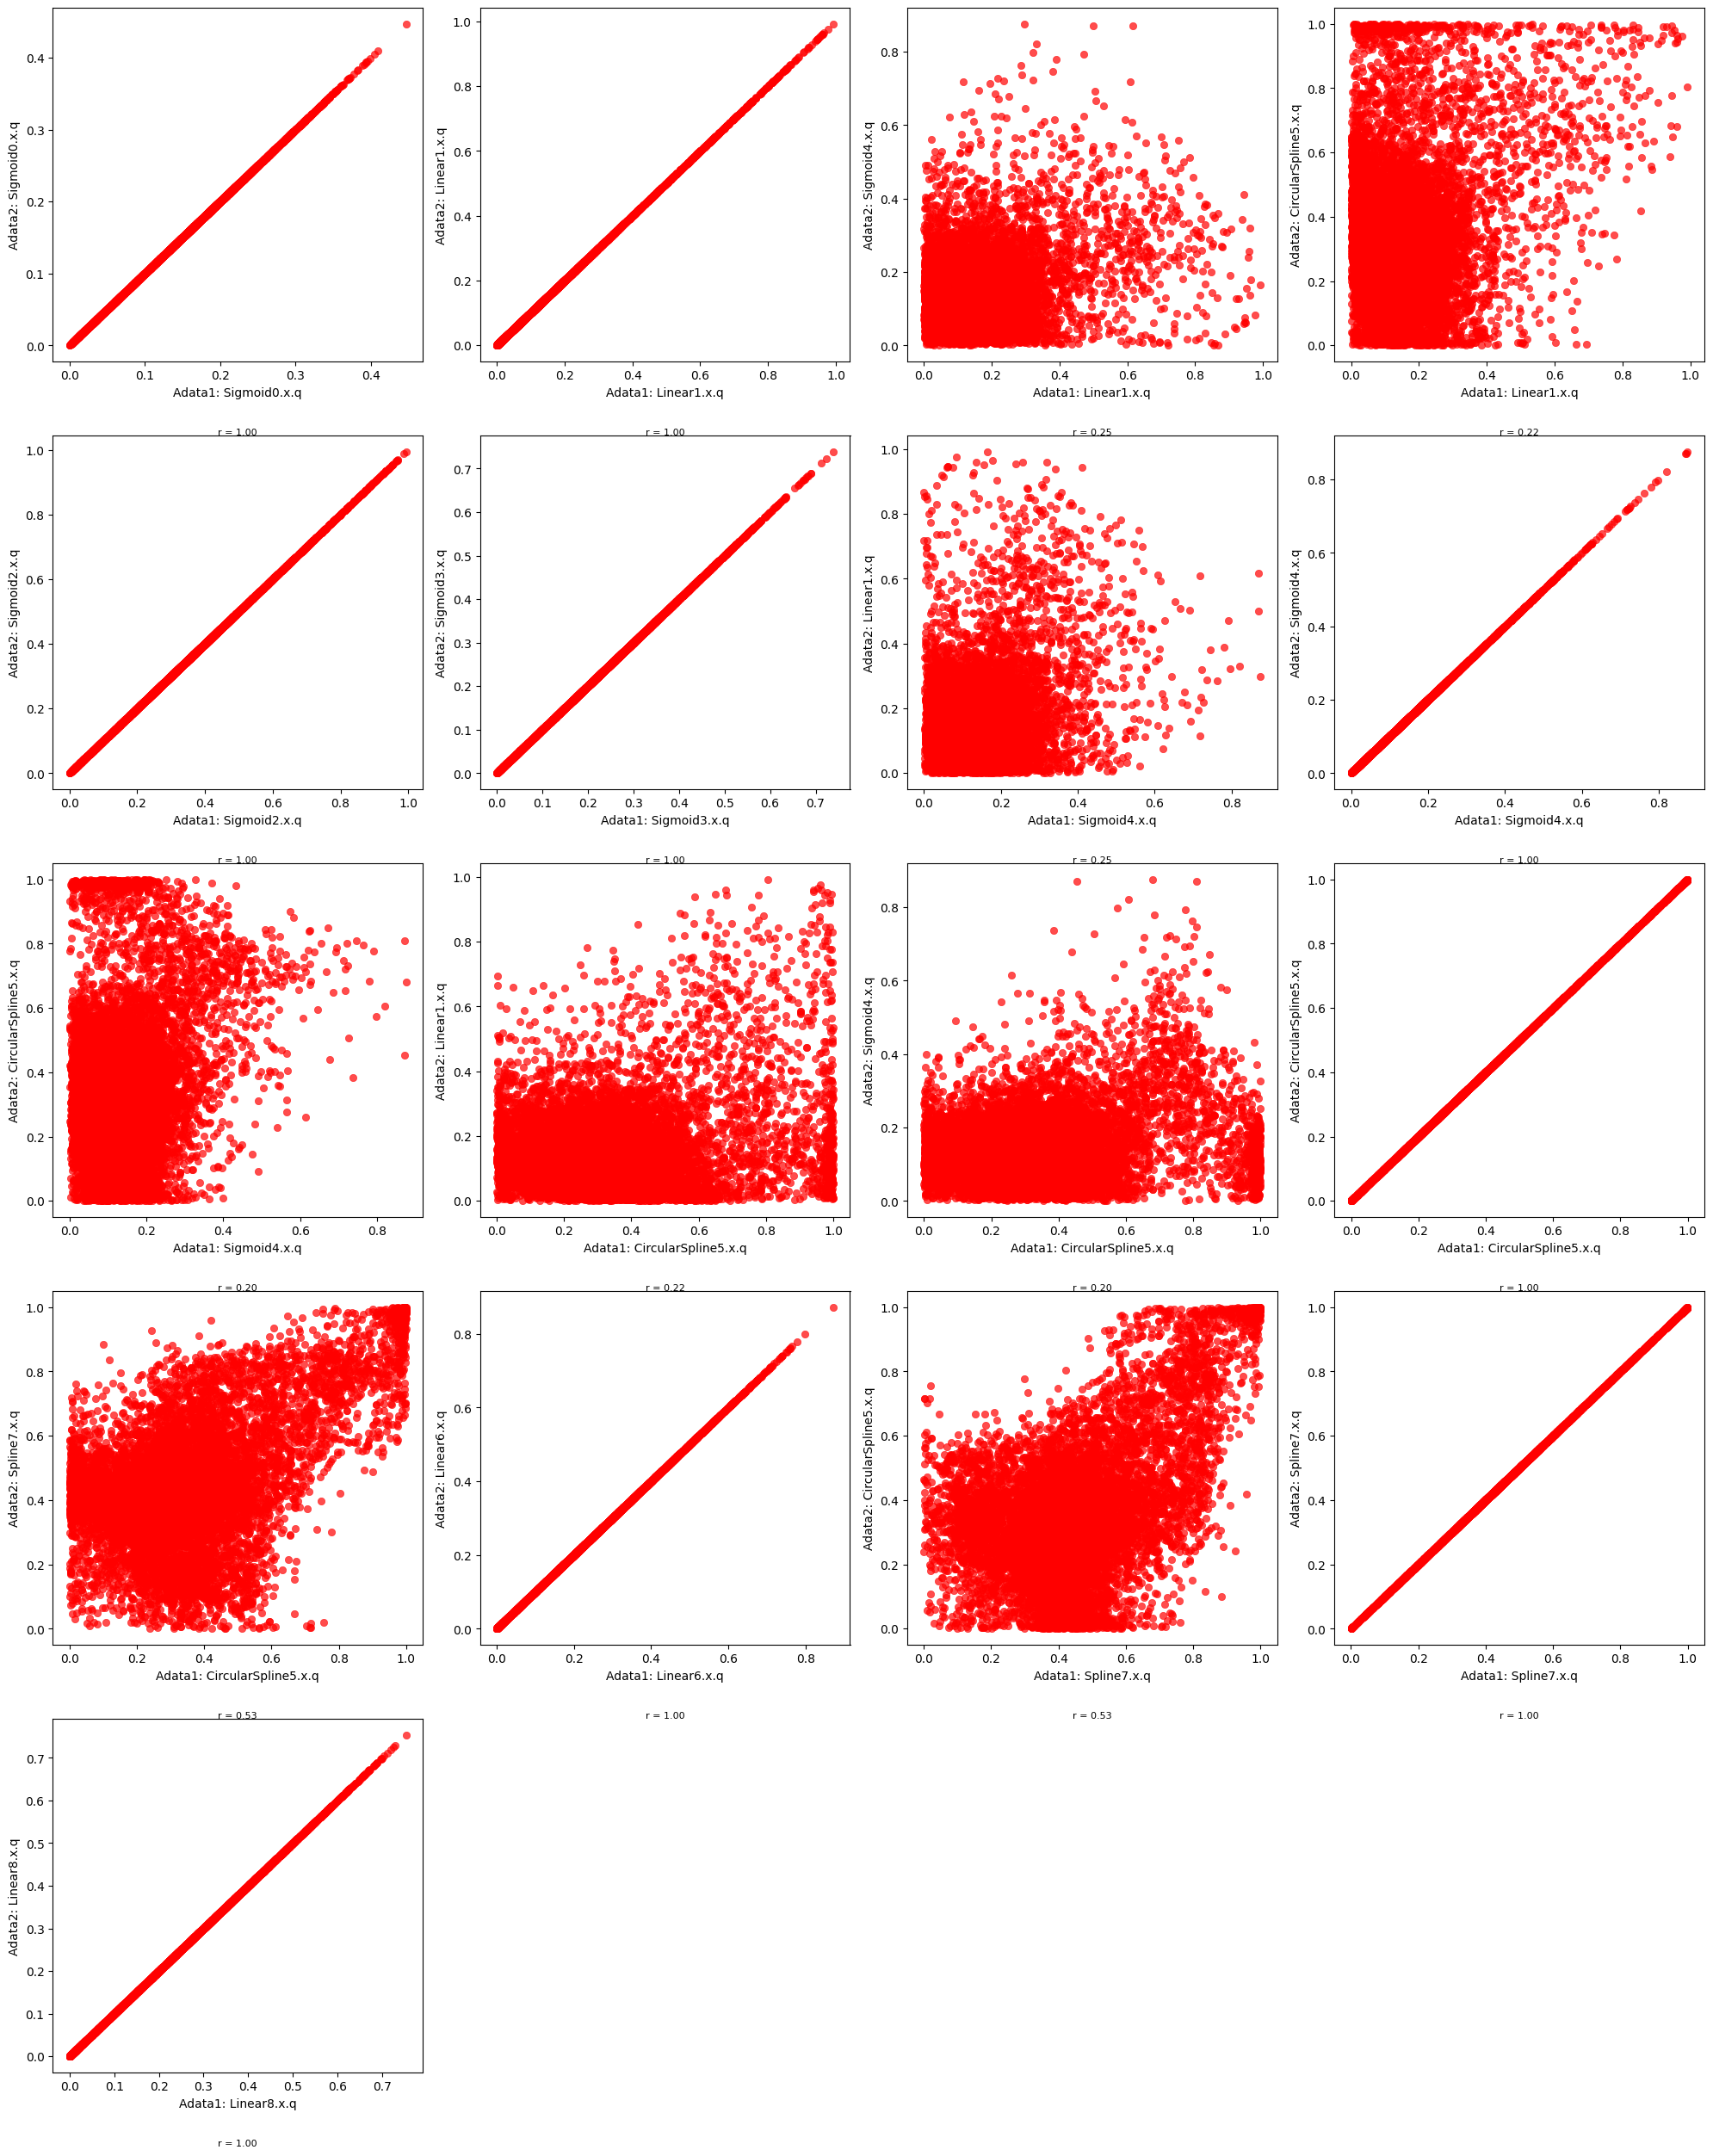

In [16]:
compare_adata_obs(original_adata,original_adata, threshold=0.2, compact=True)